In [4]:
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from rouge_score import rouge_scorer
from tqdm import tqdm
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# Use a smaller model
model_name = "facebook/bart-base"  # Instead of bart-large-cnn

# Set up the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
# Load a smaller portion of the dataset

dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1000]")  # Load only 1000 samples
dataset = dataset.train_test_split(test_size=0.1)  # Split into train and validation

In [8]:
dataset['train']

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 900
})

In [9]:
dataset['train'].shape

(900, 3)

In [10]:
dataset['train'].info

DatasetInfo(description='', citation='', homepage='', license='', features={'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', dataset_name='cnn_dailymail', config_name='3.0.0', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=1261703785, num_examples=287113, shard_lengths=[115705, 115704, 55704], dataset_name='cnn_dailymail'), 'validation': SplitInfo(name='validation', num_bytes=57732412, num_examples=13368, shard_lengths=None, dataset_name='cnn_dailymail'), 'test': SplitInfo(name='test', num_bytes=49925732, num_examples=11490, shard_lengths=None, dataset_name='cnn_dailymail')}, download_checksums={'hf://datasets/cnn_dailymail@96df5e686bee6baa90b8bee7c28b81fa3fa6223d/3.0.0/train-00000-of-00003.parquet': {'num_bytes': 256540614, 'checksum': None}, 'hf://datasets/cnn_dailymail@96df5e686bee6baa90b8bee7c28b81f

In [11]:
dataset['train'].features

{'article': Value(dtype='string', id=None),
 'highlights': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None)}

In [14]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have",
    "couldn't": "could not",

    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not",

    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "how's": "how is",

    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",

    "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would",

    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam",

    "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
    "must've": "must have",

    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock",

    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have",

    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
    "she's": "she is",

    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as",

    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would",

    "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have",

    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have",

    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are",

    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
    "what're": "what are",

    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is",

    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have",

    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
    "won't've": "will not have",

    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

In [15]:
def replace_contractions(text):
    def replace(match):
        return contraction_mapping[match.group(0)]

    return re.sub("|".join(contraction_mapping.keys()), replace, text)


def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-printable characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # text = text.lower()
    return text

In [16]:
# Preprocess function
def preprocess_function(data):
    # Clean the input articles
    cleaned_articles = [clean_text(replace_contractions(doc)) for doc in data["article"]]

    # Clean the summaries
    cleaned_summaries = [clean_text(replace_contractions(summary)) for summary in data["highlights"]]

    # Add summarize prefix to input text
    inputs = [f"summarize: {doc}" for doc in cleaned_articles]

    # Tokenize inputs
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Tokenize labels (summaries)
    labels = tokenizer(cleaned_summaries, max_length=128, truncation=True, padding="max_length")

    # Add labels to model inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


# Apply preprocessing
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [17]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [18]:
# Compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = [scorer.score(pred, label) for pred, label in zip(decoded_preds, decoded_labels)]

    return {
        'rouge1': np.mean([score['rouge1'].fmeasure for score in scores]),
        'rouge2': np.mean([score['rouge2'].fmeasure for score in scores]),
        'rougeL': np.mean([score['rougeL'].fmeasure for score in scores]),
    }

In [19]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=10,  # Log every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=False,
    gradient_accumulation_steps=16,
)

In [20]:
len(tokenized_datasets['train']), len(tokenized_datasets["test"])

(900, 100)

In [21]:
try:
    # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()
except Exception as e:
    # Handling any exceptions that may occur during the process and printing the error message.
    print('Exception occurred: ', e)

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
100,3.165100,2.672405,0.247109,0.098124,0.199649


In [22]:
# Evaluate the model
results = trainer.evaluate()
results

{'eval_loss': 2.511204719543457,
 'eval_rouge1': 0.24960283312985776,
 'eval_rouge2': 0.098439520578874,
 'eval_rougeL': 0.20094164764898617,
 'eval_runtime': 49.5911,
 'eval_samples_per_second': 2.016,
 'eval_steps_per_second': 1.008,
 'epoch': 4.977777777777778}

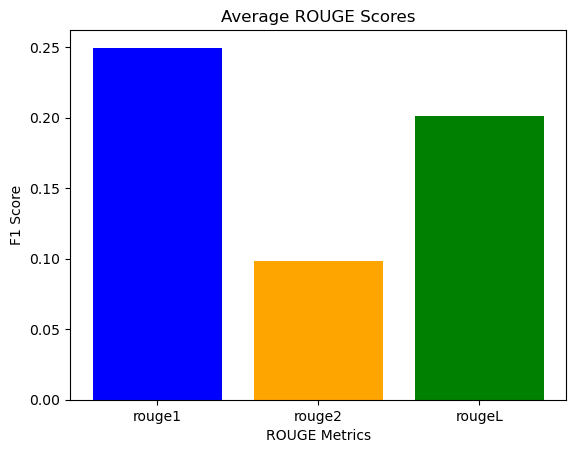

In [23]:
scores = results

rouge_names = ['rouge1', 'rouge2', 'rougeL']
score_values = [scores[f'eval_{rouge}'] for rouge in rouge_names]

plt.bar(rouge_names, score_values, color=['blue', 'orange', 'green'])
plt.xlabel("ROUGE Metrics")
plt.ylabel("F1 Score")
plt.title("Average ROUGE Scores")
plt.show()

In [24]:
# Error analysis function
def perform_error_analysis(trainer, dataset, num_samples=10):
    errors = []
    for i in tqdm(range(min(num_samples, len(dataset)))):
        input_ids = torch.tensor([dataset[i]["input_ids"]]).to(device)
        attention_mask = torch.tensor([dataset[i]["attention_mask"]]).to(device)

        with torch.no_grad():
            outputs = trainer.model.generate(input_ids, attention_mask=attention_mask, max_length=128)

        predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        actual_summary = tokenizer.decode(dataset[i]["labels"], skip_special_tokens=True)
        input_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

        rouge_scores = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = rouge_scores.score(predicted_summary, actual_summary)

        errors.append({
            'input': input_text,
            'predicted': predicted_summary,
            'actual': actual_summary,
            'rouge_scores': scores
        })

    return errors


# Perform error analysis
error_samples = perform_error_analysis(trainer, tokenized_datasets["test"])

100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


In [26]:
# Print some error examples
for i, error in enumerate(error_samples[:5]):
    print(f"Error Example {i + 1}:")
    print(f"Input: {error['input'][:100]}...")  # the text i want to summarize
    print(f"Predicted: {error['predicted']}")  # the summarized text output
    print(f"Actual: {error['actual']}")  # the actual summary
    print(f"ROUGE-L F1: {error['rouge_scores']['rougeL'].fmeasure:.4f}")
    print("\n")


# Analyze error patterns
def analyze_error_patterns(errors):
    length_diff = []
    content_overlap = []

    for error in errors:
        pred_len = len(error['predicted'].split())
        actual_len = len(error['actual'].split())
        length_diff.append(abs(pred_len - actual_len))

        pred_set = set(error['predicted'].lower().split())
        actual_set = set(error['actual'].lower().split())
        overlap = len(pred_set.intersection(actual_set)) / len(pred_set.union(actual_set))
        content_overlap.append(overlap)

    print(f"Average length difference: {np.mean(length_diff):.2f} words")
    print(f"Average content overlap: {np.mean(content_overlap):.2f}")


analyze_error_patterns(error_samples)

Error Example 1:
Input: summarize: COPENHAGEN, Denamrk (CNN) -- What makes someone decide to become an actor? It sometimes s...
Predicted: Connie Nielsen is not typical movie star. She is a Danish actress. She was born in Elling, a small coastal village in Denmark. She grew up in Denmark and studied acting in France and Italy.
Actual: Connie Nielsen made her name playing Lucilla in Ridley Scott's "Gladiator" She has appeared in movies dealing with the wars in Afghanistan and Iraq. Nielsen speaks seven languages and is passionate about art and literature.
ROUGE-L F1: 0.1972


Error Example 2:
Input: summarize: HONG KONG, China (Reuters) -- Paul Lee got his liver from an executed Chinese prisoner; K...
Predicted: China, Pakistan, Egypt, Colombia and the Philippines have been arrested for kidnapping people, drugging them and stealing their kidneys. World Health Organization estimates that 21,000 liver transplants are carried out annually. Most of the transplants involve removing part of t

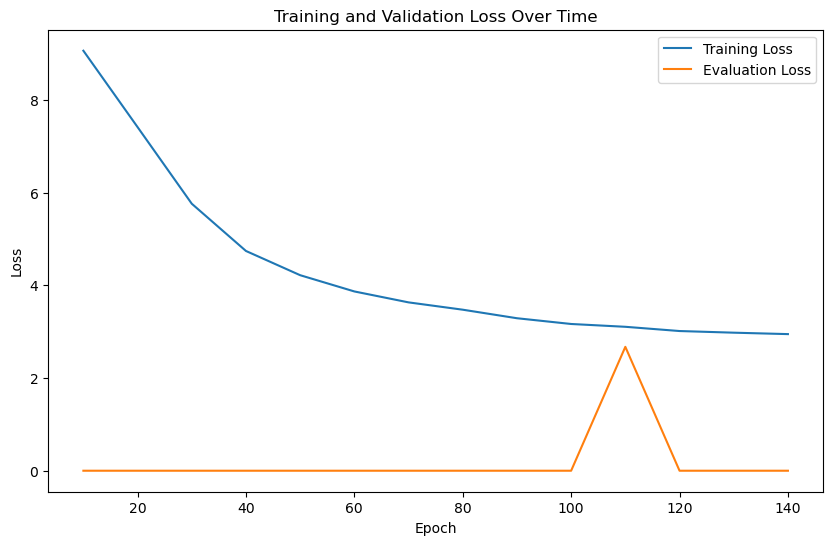

In [25]:
# train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
# steps = range(1, len(train_loss) + 1)

# Extract training and evaluation losses from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# eval_loss = [log['eval_loss'] or 0 for log in trainer.state.log_history if 'eval_loss' in log]
eval_loss = [log.get('eval_loss', 0) for log in trainer.state.log_history]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss[:len(train_loss)], label="Evaluation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.show()


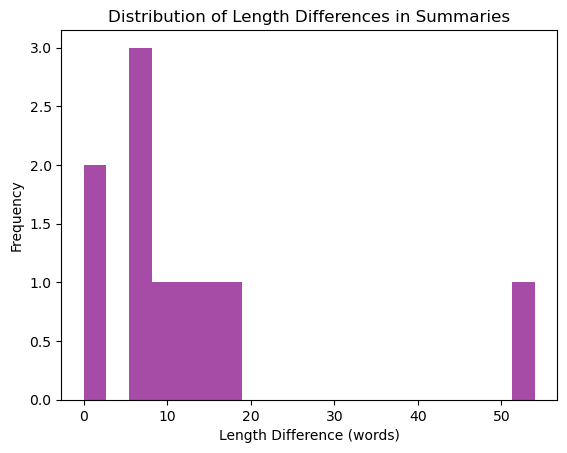

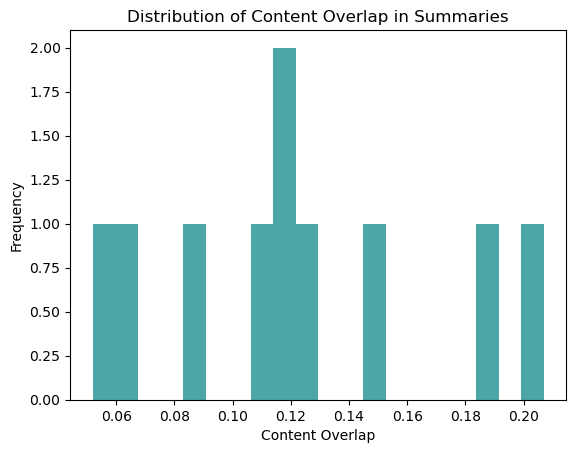

In [27]:
length_diff = [abs(len(error['predicted'].split()) - len(error['actual'].split())) for error in error_samples]
content_overlap = [len(set(error['predicted'].split()).intersection(set(error['actual'].split()))) / len(
    set(error['predicted'].split()).union(set(error['actual'].split()))) for error in error_samples]

plt.hist(length_diff, bins=20, color='purple', alpha=0.7)
plt.xlabel("Length Difference (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Length Differences in Summaries")
plt.show()

plt.hist(content_overlap, bins=20, color='teal', alpha=0.7)
plt.xlabel("Content Overlap")
plt.ylabel("Frequency")
plt.title("Distribution of Content Overlap in Summaries")
plt.show()


In [28]:
paragraph = '''
Pennsylvania Gov. Josh Shapiro said former President Donald Trump has left the Butler, Pennsylvania, area following the rally shooting Saturday.
“Under the protection of US Secret Service and with the assistance of the Pennsylvania State Police, former President Trump has now left the Butler area,” Shapiro said in a statement posted to X. “Lori and I are thankful that his team reports that he is fine and we continue to wish him a full and speedy recovery.”
“We mourn the loss of life and pray for the two victims who are being treated at this time,” he added. “I am grateful for all law enforcement who responded, protected the former president, and worked to bring the situation under control.”
Federal law enforcement officials will continue to lead on the investigation into the shooting, Shapiro said. Meanwhile, Pennsylvania State Police will lead the investigation into the shooting of the other victims. Shapiro said he has been communicating with law enforcement on the ground in Pennsylvania and has spoken with President Joe Biden, who “offered his full support.”
Shapiro said he knows “how painful and shocking this event is to so many of our fellow Pennsylvanians.” He asked “that we treat our fellow Americans with respect and join together to universally condemn the unacceptable violence we witnessed earlier today in Butler.”
'''

In [29]:
def generate_summary(text, max_length=128):
    inputs = tokenizer("summarize: " + text, return_tensors="pt", truncation=True, max_length=512).to(device)
    outputs = model.generate(**inputs, max_length=max_length, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary


In [30]:
summary = generate_summary(paragraph)
summary

'Pennsylvania Gov. Josh Shapiro says former President Donald Trump has left the Butler, Pennsylvania, area following the rally shooting. Shapiro: “We mourn the loss of life and pray for the two victims who are being treated at this time”“Under the protection of US Secret Service and with the assistance of the Pennsylvania State Police, former President Trump has now left the area,” Shapiro said in a statement posted to Facebook. “Lori and I are thankful that his team reports that he is fine and we continue to wish him a full and speedy recovery.”'

In [ ]:
# Save the model
model_save_path = "./transformer_model4"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)